In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dython.nominal import associations, correlation_ratio, cramers_v

/home/ronald/anaconda3/envs/tp_analisis_de_datos/lib/python3.11/site-packages/dython/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


In [2]:
# Leemos el csv, es un archivo grande
df = pd.read_csv("data/GEDEvent_v25_1.csv", low_memory=False)

In [3]:
# Eliminamos duplicados y volvemos a contar filas
df.drop_duplicates(inplace=True)
print(f"Número de filas: {df.shape[0]}")

Número de filas: 385918


In [4]:
df_resumen = pd.DataFrame({
    'variable_name': df.columns,
    'dtype': df.dtypes.astype(str),
    'no nulos': df.count(),
    'unicos': df.nunique(),
    'unicos_%': (df.nunique()/df.count()*100).round(0).astype(int),
    'nulos': df.isna().sum(),
    'nulos_%': (df.isna().mean() * 100).round(0).astype(int),

})
df_resumen.reset_index(drop=True, inplace=True)
df_resumen

,variable_name,dtype,no nulos,unicos,unicos_%,nulos,nulos_%
0,id,int64,385918,385918,100,0,0
1,relid,object,385918,385918,100,0,0
2,year,int64,385918,36,0,0,0
3,active_year,bool,385918,2,0,0,0
4,code_status,object,385918,1,0,0,0
5,type_of_violence,int64,385918,3,0,0,0
6,conflict_dset_id,int64,385918,1484,0,0,0
7,conflict_new_id,int64,385918,1531,0,0,0
8,conflict_name,object,385918,1529,0,0,0
9,dyad_dset_id,int64,385918,1740,0,0,0


In [5]:
# Ajustamos las variables con fecha (mantenemos 'year' como int)
df['date_start'] = pd.to_datetime(df['date_start'], errors='coerce')
df['date_end'] = pd.to_datetime(df['date_end'], errors='coerce')

In [6]:
# Mapeamos la variable nominal 'type_of_violence' a 1: state-based conflict 2: non-state conflict 3: one-sided violence
df["type_of_violence"] = df["type_of_violence"].map({1: "state-based conflict", 2: "non-state conflict", 3: "one-sided violence"}).astype("category")

In [7]:
# Ajustamos las variables categóricas de alta cardinalidad
categoricas= ['id', 'relid', 'code_status', 'conflict_dset_id', 'dyad_dset_id', 'side_a_dset_id', 'side_b_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_new_id', 'dyad_name', 'side_a_new_id',
              'side_a', 'side_b_new_id', 'side_b', 'source_article', 'source_date', 'source_office', 'source_headline', 'source_original', 'where_coordinates', 'where_description', 'adm_1', 'adm_2', 'geom_wkt', 'priogrid_gid', 'country', 'country_id', 'region', 'gwnoa', 'gwnob']
for categorica in categoricas:
    df[categorica] = df[categorica].astype("category")

Analizamos correlaciones entre variables

In [8]:
cols = [
    'conflict_dset_id', 'conflict_new_id', 'conflict_name',
    'dyad_dset_id', 'dyad_new_id', 'dyad_name',
    'side_a_dset_id', 'side_a_new_id', 'side_a',
    'side_b_dset_id', 'side_b_new_id', 'side_b',
    'adm_1', 'adm_2', 
    'country', 'country_id',
    'region',
    'event_clarity',
    'gwnoa', 'gwnob',
    'number_of_sources', 
#    'where_prec', 'where_coordinates', 'latitude', 'longitude', 'priogrid_gid', (las saco porque me rompe la matriz de correlaciones)
    'date_start', 'date_end',
    'deaths_a', 'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low' 
]

In [9]:
result = associations(
    df[cols],
    nominal_columns='auto',
    plot=False
)

/home/ronald/anaconda3/envs/tp_analisis_de_datos/lib/python3.11/site-packages/dython/nominal.py:632: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  lambda col: col.view(np.int64), axis=0


<Axes: >

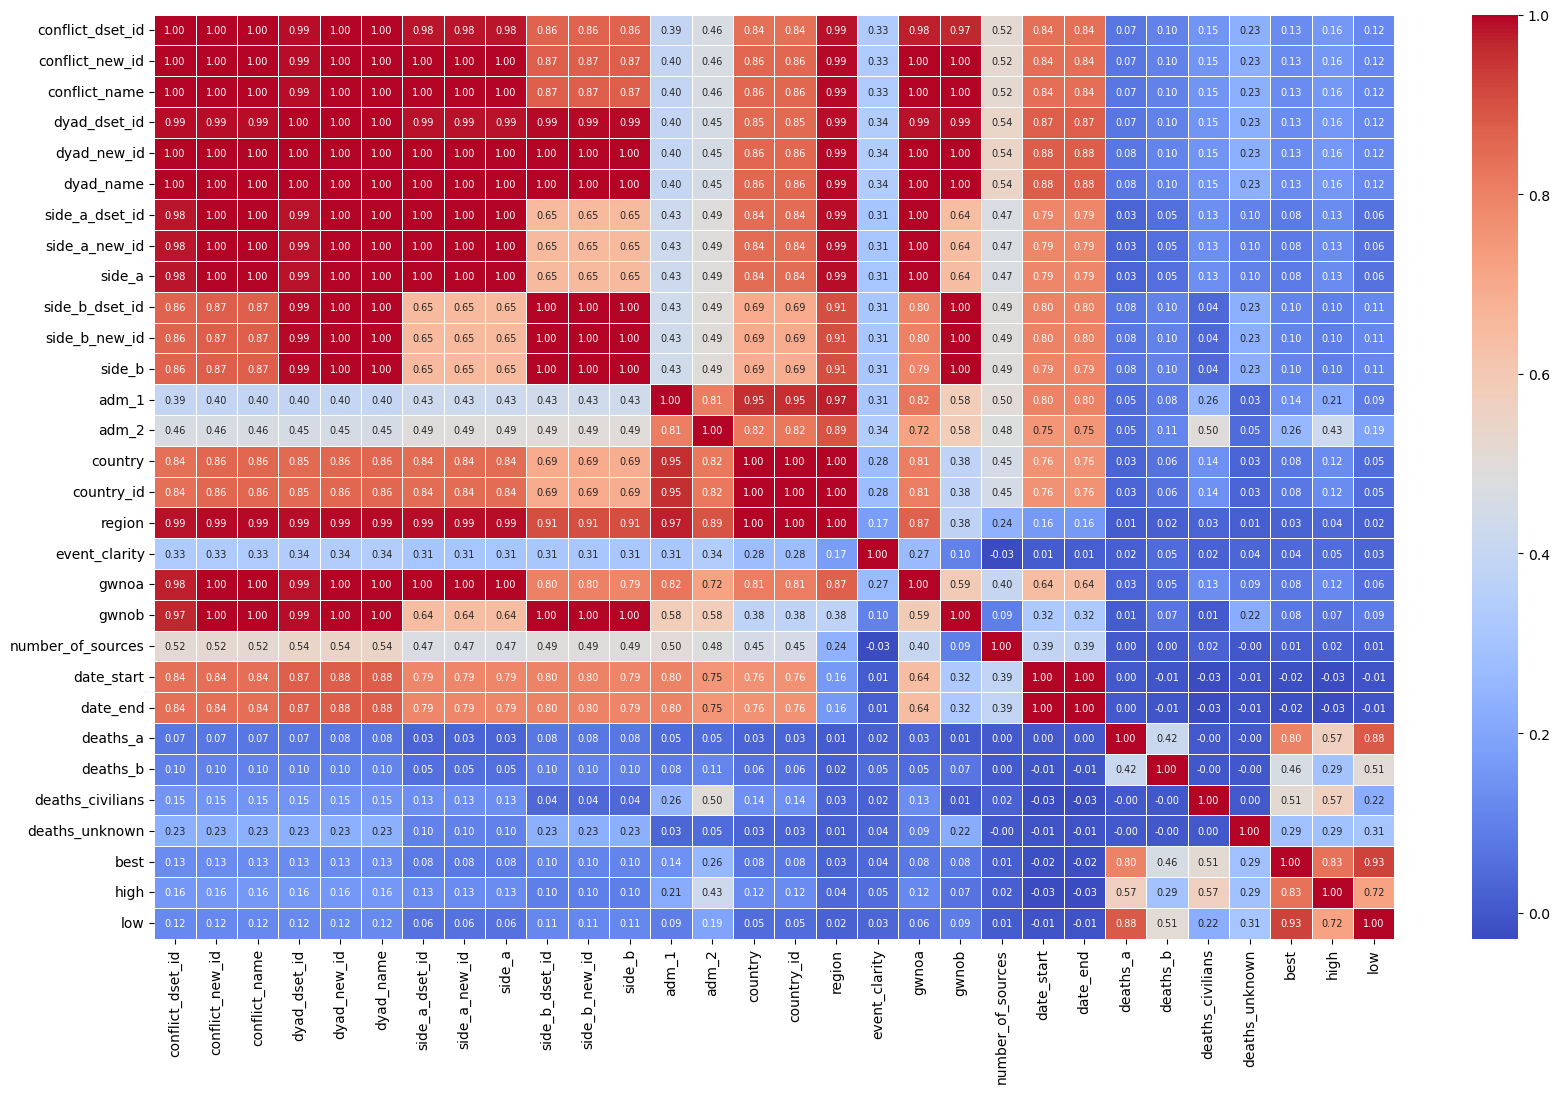

In [10]:
corr_matrix = result['corr']
plt.figure(figsize=(20, 12))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    annot_kws={"size": 7},
    linewidths=0.5
)


In [11]:
df['sum_deaths']=df['deaths_a']+df['deaths_b']+df['deaths_civilians']+df['deaths_unknown']-df['best']

In [12]:
check_muertes=df['sum_deaths'].sum()
print(check_muertes)

0


In [13]:
df['col_concat'] = 'POINT ('+ df['longitude'].astype(str) + ' ' + df['latitude'].astype(str) + ')'

In [14]:
coincidences = (df['col_concat']==df['geom_wkt']).sum()
print(coincidences)

358384


In [15]:
variables=pd.read_csv("data/variables.csv", encoding="utf-8", sep=";")
variables

,variable_name,description,type Pandas,eliminate,comment
0,id,Identificador unico del evento,int64,True,Valor único por observación
1,relid,Identificador interno del evento (cambia si el...,object,True,Valor único por observación
2,year,Ano del evento,int64,False,NaN
3,active_year,True si el evento pertenece a un conflicto act...,bool,False,NaN
4,code_status,Si el registro est ok (clear) o si hay que ch...,object,True,Valor único (solo contiene 'clear')
5,type_of_violence,"Tipo de violencia: 1. Conflicto entre estados,...",int64,False,NaN
6,conflict_dset_id,Identificador deprecado,int64,True,V=1 con [side_a]
7,conflict_new_id,Identificador único del conflicto (usar esto p...,int64,True,V=1 con [side_a]
8,conflict_name,Nombre del conflicto,object,True,V=1 con [side_a]
9,dyad_dset_id,Identificador deprecado,int64,True,V=1 con [side_a]
